# ele.gan.t facades

This tutorial demonstrates how to build and train a conditional generative adversarial network (cGAN) using the pix2pix python library developed through our end of study project at Le Wagon bootcamp.

**Authors** : Amor Hamza, Chaigneau Colin, Duverger Alexandre, Sadaouni Oumnia

## Import libraries

In [ ]:
!pip install -q -U pip
!pip install -q git+https://github.com/aduverger/pix2pix

In [4]:
from pix2pix.data import *
from pix2pix.cgan import *
import random
import time
import pickle
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from ipywidgets import interact
from IPython import display

## Load and prepare the dataset

First download the dataset from Berkeley and save it on this Colab temporary drive

In [5]:
!curl -O http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.7M  100 28.7M    0     0  2375k      0  0:00:12  0:00:12 --:--:-- 2559k


Get the tf.datasets you need for training a cGan model on the facades dataset.


In [6]:
ds_train, ds_val, ds_test = get_dataset(host='/content/facades')

Importing train DONE!
Importing val DONE!
Importing test DONE!


## Create the models

GANs rely on a generator that learns to generate new images, and a discriminator that learns to distinguish synthetic images from real images.

### The Generator

#### Encoder-Decoder

The Encoder-Decoder generator uses tf.keras.layers.Conv2D (downsampling) and tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a image : encoder-decoder.

We use strided convolutions instead of pooling layers, as describe in deep convolutional GAN original paper. All ReLU are leaky, with slope 0.2. Dropout with a rate of 50% are applied to the first 3 layers of the decoder.

encoder architecture:
C64-C128-C256-C512-C512-C512-C512-C512

decoder architecture:
CD512-CD512-CD512-C512-C256-C128-C64

In [7]:
def make_generator_encoder_model():
    encoder = tf.keras.Sequential()

    encoder.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(256, 256, 3)))
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 128, 128, 64)

    encoder.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 64, 64, 128)

    encoder.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 32, 32, 256)

    encoder.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 16, 16, 512)

    encoder.add(layers.Conv2D(512, (4,4), strides=(2,2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 8, 8, 512)

    encoder.add(layers.Conv2D(512, (3,3), strides=(2,2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 4, 4, 512)

    encoder.add(layers.Conv2D(512, (2,2), strides=(2,2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 2, 2, 512)

    encoder.add(layers.Conv2D(512, (2,2), strides=(2,2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(alpha=0.2))
    assert encoder.output_shape == (None, 1, 1, 512)

    encoder.add(layers.Flatten())
    assert encoder.output_shape == (None, 512)

    encoder.add(layers.Dense(512, activation='tanh'))

    return encoder

Visualize the encoder model architecture:

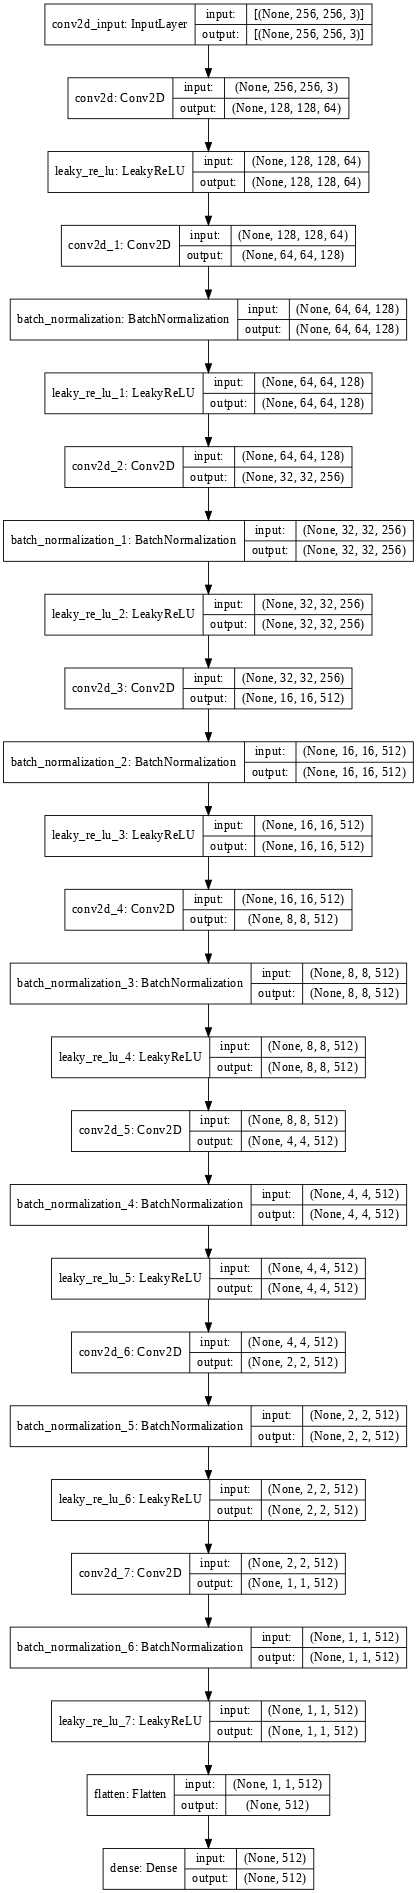

In [8]:
encoder = make_generator_encoder_model()
tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=64)

In [9]:
def make_generator_decoder_model():
    decoder = tf.keras.Sequential()

    decoder.add(layers.Dense(2*2*512, input_shape=(512,), activation='tanh'))

    decoder.add(layers.Reshape((2,2,512)))

    decoder.add(layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.ReLU())
    encoder.add(layers.Dropout(0.5))
    assert decoder.output_shape == (None, 4, 4, 512)

    decoder.add(layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.ReLU())
    encoder.add(layers.Dropout(0.5))
    assert decoder.output_shape == (None, 8, 8, 512)

    decoder.add(layers.Conv2DTranspose(512, (3,3), strides=(2,2), padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.ReLU())
    encoder.add(layers.Dropout(0.5))
    assert decoder.output_shape == (None, 16, 16, 512)

    decoder.add(layers.Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.ReLU())
    assert decoder.output_shape == (None, 32, 32, 512)

    decoder.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.ReLU())
    assert decoder.output_shape == (None, 64, 64, 256)

    decoder.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.ReLU())
    assert decoder.output_shape == (None, 128, 128, 128)

    decoder.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.ReLU())
    assert decoder.output_shape == (None, 256, 256, 64)

    decoder.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', activation='tanh'))

    assert decoder.output_shape == (None, 256, 256, 3)

    return decoder

Visualize the decoder model architecture:

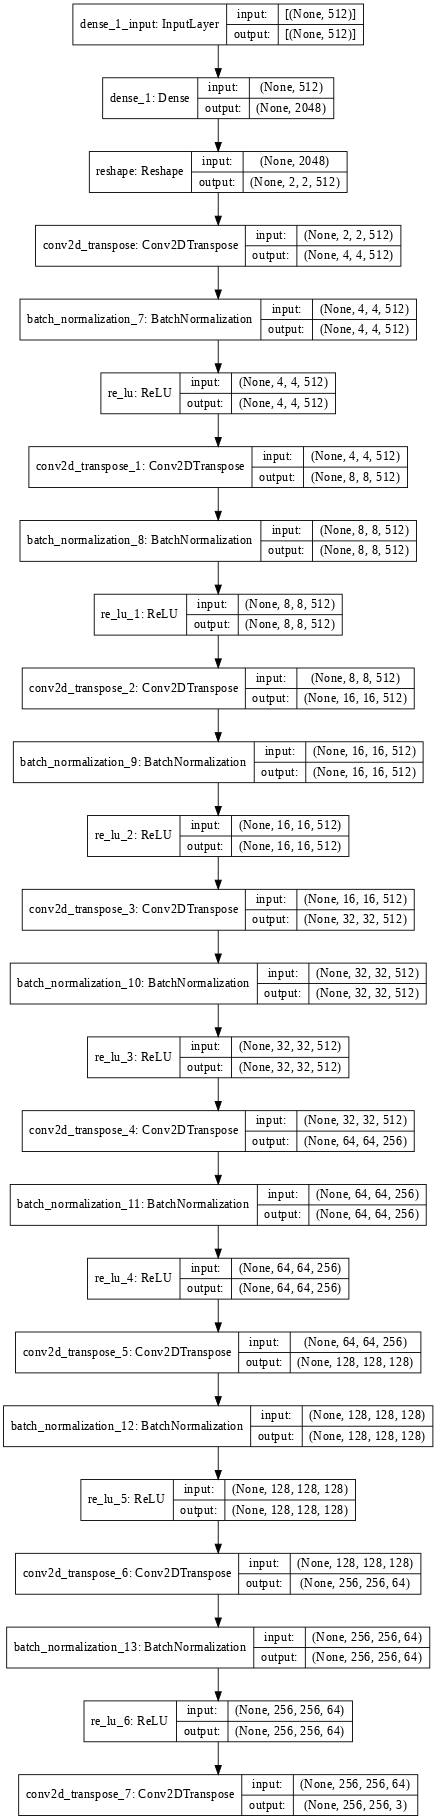

In [10]:
decoder = make_generator_decoder_model()
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi=64)

In [11]:
 def make_generator_encoder_decoder_model(encoder, decoder):
    inp = layers.Input((256, 256, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    encoder_decoder = tf.keras.Model(inp, decoded)
    return encoder_decoder

Visualize the encoder-decoder model architecture:

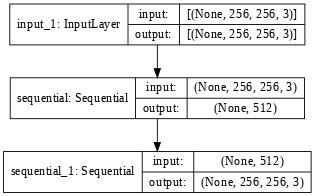

In [12]:
encoder_decoder = make_generator_encoder_decoder_model(encoder, decoder)
tf.keras.utils.plot_model(encoder_decoder, show_shapes=True, dpi=64)

#### U-net

A U-Net architecture actually performs better as a generator than a Encoder-Decoder.

The U-Net architecture is identical to the Encoder-Decoder except with skip connections between each layer i in the encoder and layer n−i in the decoder, where n is the total number of layers. The skip connections concatenate activations from layer i to layer n − i. This changes the number of channels in the decoder:
CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

Weights are initialized from a Gaussian distribution with mean 0 and standard deviation 0.02.

In [13]:
def block_conv2D(filters, kernel_size=4, strides=(2,2), with_batch_norm=True, relu_alpha=0.3):
    '''
        Return a block of layers consisting of Conv2D-BatchNormal-LeakyReLU or Conv2D-LeakyReLU layers
    '''
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer=initializer, use_bias=False))
    if with_batch_norm:
        block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU(alpha=relu_alpha))

    return block

In [14]:
def block_conv2D_transpose(filters, kernel_size=4, strides=(2,2), with_dropout=False, dropout_rate=0.5):
    '''
        Return a block of layers consisting of Conv2D-BatchNorm-Dropout-ReLU or Conv2D-BatchNorme-ReLU
    '''
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
    block = tf.keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding="same", kernel_initializer=initializer, use_bias=False))
    block.add(layers.BatchNormalization())
    if with_dropout:
        block.add(layers.Dropout(dropout_rate))
    block.add(layers.ReLU())

    return block

In [15]:
def make_generator_unet_model():

    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

    inputs = layers.Input(shape=(256, 256, 3))
    res = []

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = block_conv2D(64, with_batch_norm=False)(inputs)
    # Shape = (128, 128, 64)
    res.append(x)

    x = block_conv2D(128)(x)
    # Shape = (64, 64, 128)
    res.append(x)

    x = block_conv2D(256)(x)
    # Shape = (32, 32, 256)
    res.append(x)

    x = block_conv2D(512)(x)
    # Shape = (16, 16, 512)
    res.append(x)

    x = block_conv2D(512)(x)
    # Shape = (8, 8, 512)
    res.append(x)

    x = block_conv2D(512)(x)
    # Shape = (4, 4, 512)
    res.append(x)

    x = block_conv2D(512)(x)
    # Shape = (2, 2, 512)
    res.append(x)

    x = block_conv2D(512, with_batch_norm=False)(x)
    # Shape = (1, 1, 512) --> LATENT SPACE


    ### [Second half of the network: upsampling inputs] ###

    x = block_conv2D_transpose(512, with_dropout=True)(x)
    x = layers.Concatenate()([x, res[-1]])
    # Shape = (2, 2, 1024)

    x = block_conv2D_transpose(512, with_dropout=True)(x)
    x = layers.Concatenate()([x, res[-2]])
    # Shape = (4, 4, 1024)

    x = block_conv2D_transpose(512, with_dropout=True)(x)
    x = layers.Concatenate()([x, res[-3]])
    # Shape = (8, 8, 1024)

    x = block_conv2D_transpose(512)(x)
    x = layers.Concatenate()([x, res[-4]])
    # Shape = (16, 16, 1024)

    x = block_conv2D_transpose(256)(x)
    x = layers.Concatenate()([x, res[-5]])
    # Shape = (32, 32, 512)

    x = block_conv2D_transpose(128)(x)
    x = layers.Concatenate()([x, res[-6]])
    # Shape = (64, 64, 256)

    x = block_conv2D_transpose(64)(x)
    x = layers.Concatenate()([x, res[-7]])
    # Shape = (128, 128, 128)

    # Last ouput 
    outputs = layers.Conv2DTranspose(3, kernel_size=4, strides=(2,2), activation="tanh", kernel_initializer=initializer, padding="same")(x)
    # Shape = (256, 256, 3)

    # Define the model
    model = tf.keras.Model(inputs, outputs)

    return model

Visualize the U-Net model architecture

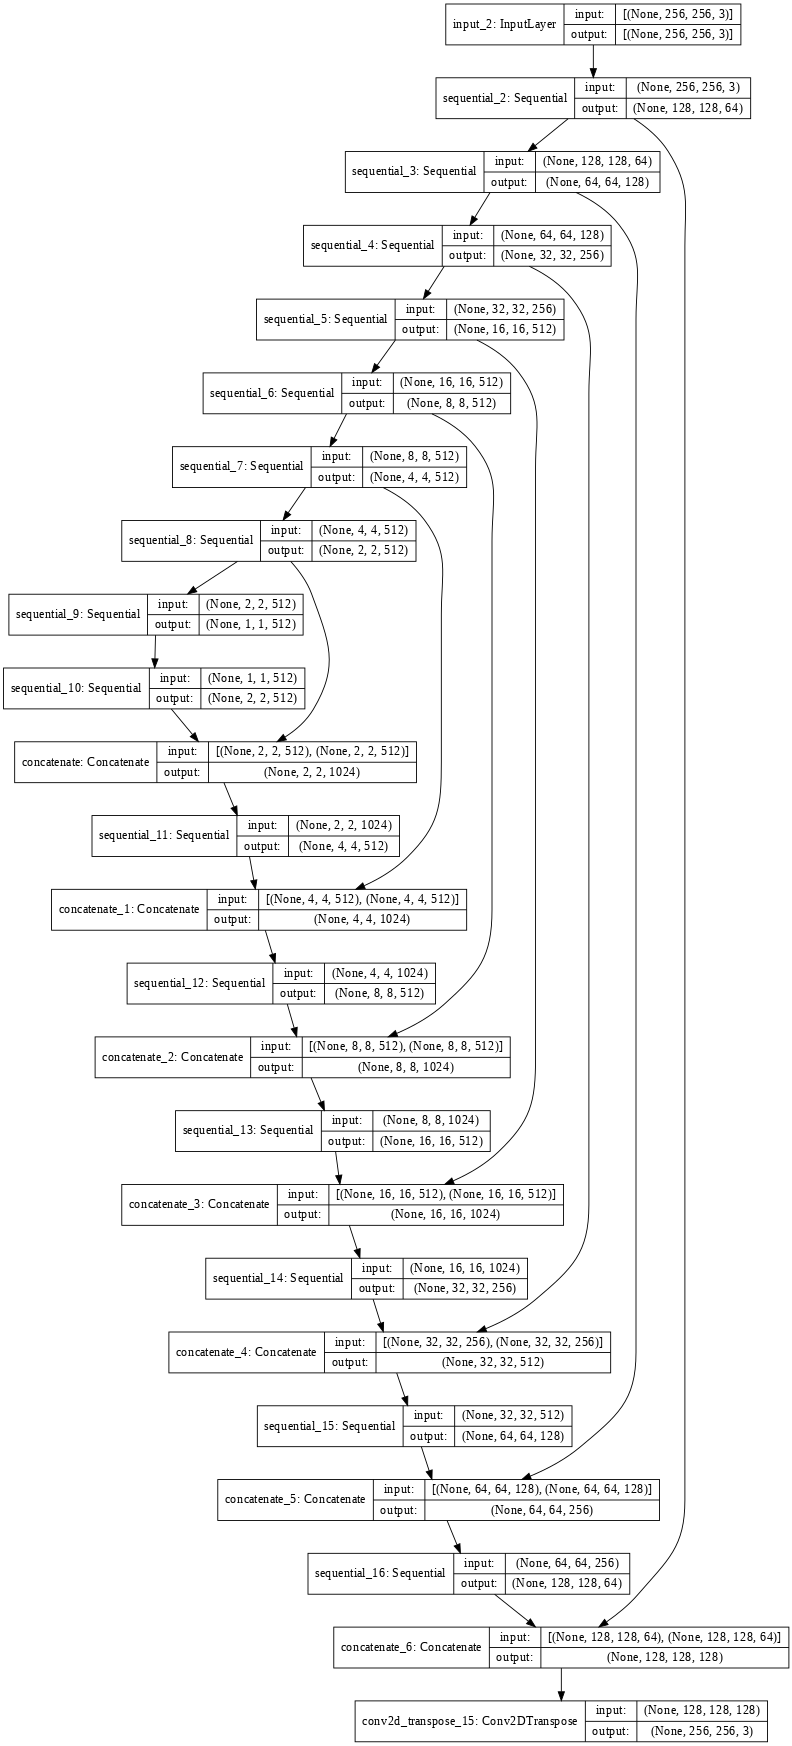

In [16]:
unet = make_generator_unet_model()
tf.keras.utils.plot_model(unet, show_shapes=True, dpi=64)

### The Discriminator

The discriminator is a CNN-based image classifier : C64-C128-C256-C512-C512-C512

In [17]:
def make_discriminator_model(alpha=0.3, cgan_mode=False):

    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

    discriminator = tf.keras.Sequential()
    if cgan_mode:
        discriminator.add(layers.Conv2D(64, 4, strides=(2,2), input_shape=(256, 256, 6), kernel_initializer=initializer, padding='same'))
    else:
        discriminator.add(layers.Conv2D(64, 4, strides=(2,2), input_shape=(256, 256, 3), kernel_initializer=initializer, padding='same'))
    discriminator.add(layers.LeakyReLU(alpha=alpha))
    # Shape = (128, 128, 64)

    discriminator.add(layers.Conv2D(128, 4, strides=(2,2), kernel_initializer=initializer, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(alpha=alpha))
    # Shape = (64, 64, 128)

    discriminator.add(layers.Conv2D(256, 4, strides=(2,2), kernel_initializer=initializer, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(alpha=alpha))
    # Shape = (32, 32, 256)

    discriminator.add(layers.Conv2D(512, 4, strides=(2,2), kernel_initializer=initializer, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(alpha=alpha))
    # Shape = (16, 16, 512)

    discriminator.add(layers.Conv2D(512, 4, strides=(2,2), kernel_initializer=initializer, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(alpha=alpha))
    # Shape = (8, 8, 512)

    discriminator.add(layers.Conv2D(512, 4, strides=(2,2), kernel_initializer=initializer, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(alpha=alpha))
    # Shape = (4, 4, 512)

    discriminator.add(layers.Flatten())

    discriminator.add(layers.Dense(1, kernel_initializer=initializer))

    return discriminator

Visualize the discriminator model architecture

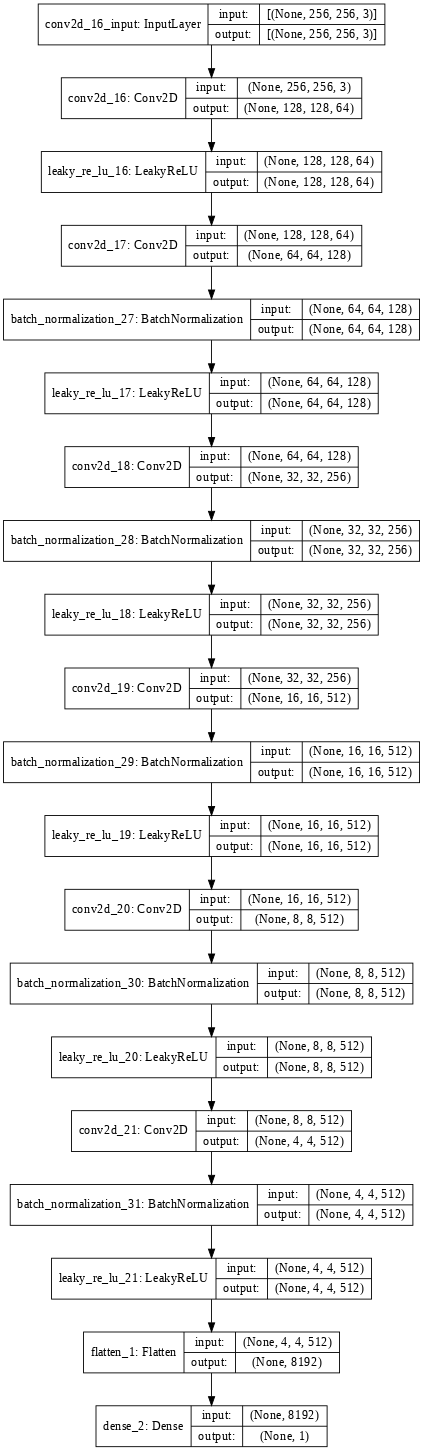

In [18]:
discriminator = make_discriminator_model()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

The research paper introcuded the concept of convolutional “PatchGAN” classifier, which only penalizes structure at the scale of image patch. This discriminator tries to classify if each 70x70 patch in an image is real or fake. We run this discriminator convolutionally across the image, averaging all responses to provide the ultimate output of the Discriminator.

In [19]:
def downsample(filters, size, apply_batchnorm=True, alpha=0.3):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU(alpha=alpha))

  return result

In [20]:
def make_patch_discriminator_model(cgan_mode=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    if cgan_mode:
        inp = tf.keras.layers.Input(shape=[256, 256, 6])
    else:
        inp = tf.keras.layers.Input(shape=[256, 256, 3])

    down1 = downsample(64, 4, False)(inp)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

Visualize the Patch-discriminator model architecture

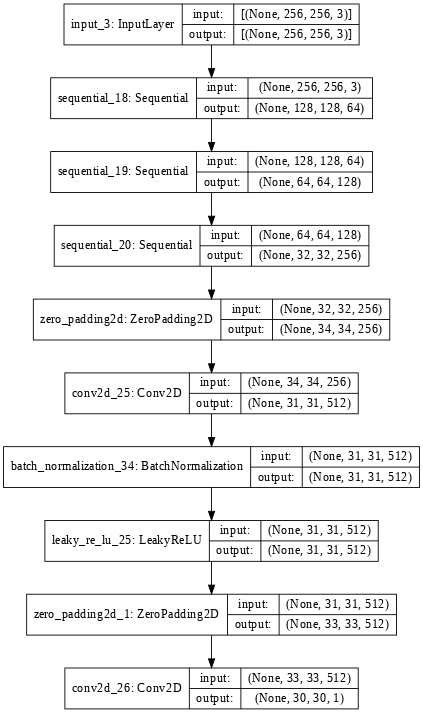

In [21]:
patch_discriminator = make_patch_discriminator_model()
tf.keras.utils.plot_model(patch_discriminator, show_shapes=True, dpi=64)

## Train the model

Instantiate a cGAN model

In [22]:
generator = make_generator_unet_model()
#discriminator = make_discriminator_model(cgan_mode=True)
discriminator = make_patch_discriminator_model(cgan_mode=True)
model = CGAN(generator, discriminator, cgan_mode=True)

Little hack to always have the same images displayed during the training process. If you prefer to have random images at each epoch, don't run this cell

In [23]:
model.random_sample=False
model.paint_train, model.real_train = \
                        load_and_split_image('/content/facades/train/20.jpg')
model.paint_val, model.real_val = \
                        load_and_split_image('/content/facades/val/21.jpg')

Use the cell below if you wan't to change the optimizers of the generator and discriminator. It can be usefull if you want to lower their learning rates after you already trained your model for a certain number of epochs. 

**Don't run this cell if you start your training from scratch.**

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
model.compile(gen_optimizer, disc_optimizer)

Then finally, train your model :

In [ ]:
# Use `init` to start over your previous training.
# e.g. : you trained your model for 150 epochs. Then set init=150 so that your model will start training at epoch=150
init = 0 
n_epoch = 200
model.fit(train_ds=ds_train, val_ds=ds_val,
          epochs=init+n_epoch, initial_epoch=init,
          epoch_gen=5, epoch_disc=0,
          k=1, l1_lambda=100)

## Test and save your work

### Save and load models

Save model, history and images

In [ ]:
model_name = 'my_model'
model.generator.save(f'{model_name}/generator'+'.h5', save_format='h5')
model.discriminator.save(f'{model_name}/discriminator'+'.h5', save_format='h5')
hist_file = open(f'{model_name}/history.pkl', 'wb')
pickle.dump(model.history, hist_file)
hist_file.close()

You can load your own model if you want. Here, we provide an already trained model, which can also be used from our website [YesWeGan](https://yeswegan.herokuapp.com/).
Download the [trained model from our drive](https://drive.google.com/file/d/19YAi9xt5s4GbMjb6junyXHbukn6gKGoJ/view?usp=sharing) and put it at the root of this Colab Drive. Then load the model using the cell below:


In [33]:
new_generator = tf.keras.models.load_model('elegant_facade_trained_model.h5')

### Visualize predictions

In [35]:
_, _, paint_ds_test, _, _, real_ds_test = get_facades_datasets(host='/content/facades')

Import train  -------------- DONE!
Import val    -------------- DONE!
Import test   -------------- DONE!


In [36]:
paint_test = np.array([X for batch_X in iter(paint_ds_test) for X in batch_X])
real_test = np.array([Y for batch_Y in iter(real_ds_test) for Y in batch_Y])
fake_test = new_generator(paint_test, training=True)
@interact(index = range(paint_test.shape[0]))
def plot_pred(index):
    fig, axs = plt.subplots(1, 3, figsize=(30,30))
    axs[0].imshow((paint_test[index] * 127.5 + 127.5).astype('uint8'))
    axs[0].axis('off')
    axs[1].imshow((fake_test[index] * 127.5 + 127.5).numpy().astype('uint8'))
    axs[1].axis('off')
    axs[2].imshow((real_test[index] * 127.5 + 127.5).astype('uint8'))
    axs[2].axis('off')
    plt.show()

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…